# objective :
<br>Applying knn to classify the amazon food reviews.

In [152]:
import sqlite3 as s
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score


In [153]:
con=s.connect("database.sqlite")
con

In [154]:
data=pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3",con)
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [155]:
#function to change the score to positive/negative
def change(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

In [156]:
a_s=data.Score
a_s=a_s.map(change)
data.Score=a_s
data.Score.head(5)

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object

# Data cleaning

The data needs to get clean as it may have some unwanted things such as duplicates.

In [157]:
#sorting the values by product ids
data=data.sort_values("ProductId")

In [158]:
#removing the duplicates from the data
final_data=data.drop_duplicates(subset={"UserId","Text","ProfileName","Time"},keep="first",inplace=False)

In [159]:
print(final_data.shape)
print(final_data.Score.value_counts())

(364173, 10)
positive    307063
negative     57110
Name: Score, dtype: int64


In [160]:
p_data=final_data[final_data.Score=="positive"]
n_data=final_data[final_data.Score=="negative"]

In [161]:
#randomly selecting points
p_data=p_data.sample(17000)
n_data=n_data.sample(3000)

In [162]:
print(p_data.shape,n_data.shape)

(17000, 10) (3000, 10)


In [163]:
d=pd.concat((p_data,n_data))

In [165]:
d.shape

(20000, 10)

In [305]:
#sorting according to time stamp
d=d.sort_values('Time')

In [306]:
d.Score.value_counts()

positive    17000
negative     3000
Name: Score, dtype: int64

# Data preprocessing

The data should be preprocessed after cleaning it

In [167]:
import string 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [168]:
#stopwords
stop_words=set(stopwords.words("english"))
#initializing snowball stemmer
sno=SnowballStemmer("english")

In [169]:
#function to remove html tags
def cleanhtml(s):
    cleanr=re.compile("<.*?>")
    cleant=re.sub(cleanr," ",s)
    return cleant

In [170]:
#funtion to remove punctuation and special character
def cleanpunc(s): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',s)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [171]:
i=0
final=[]

for s in d.Text.values:
    f=[]
    c=cleanhtml(s)
    for w in cleanpunc(c).split():
        if w.isalpha() and len(w)>2:
            if w not in stop_words:
                sne=(sno.stem(w.lower())).encode('utf-8')
                f.append(sne)
               
            else:
                continue
        else:
            continue
    te=b" ".join(f)
    final.append(te)
    i+=1

In [172]:
#adding the preprocessed data into another column
d["cleaned"]=final

In [173]:
#checking if new column is added
d.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'cleaned'],
      dtype='object')

In [174]:
import sqlite3
conn=sqlite3.connect("future.sqlite")
c=conn.cursor()
conn.text_factory=str
d.to_sql('Reviews',conn,if_exists='replace',index=True)

# Bag of words

In [259]:
from sklearn.feature_extraction.text import CountVectorizer

In [260]:
#bigrams
count_vect=CountVectorizer(ngram_range=(1,2))

In [261]:
bdata=count_vect.fit_transform(d.cleaned.values)

In [262]:
x=bdata
y=d.Score

In [263]:
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [264]:
x_cv.shape

(4200, 408862)

In [266]:
#list of different k
neighbors=list(range(1,50,2))

I have used two ways to find k <br>1. cross_val_score <br>2. gridsearchcv

In [267]:
#cross_val_score
cv_scores=[]
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn,x_1,y_1,cv=10,scoring="accuracy")
    cv_scores.append(scores.mean())
print(cv_scores)
    

[0.8366443031712917, 0.8476446627560232, 0.8515000206632758, 0.8519288473033477, 0.8525001231414622, 0.8525715007288998, 0.8525001741254533, 0.8522858372814038, 0.8523573169097098, 0.8523572658528323, 0.8523572658528323, 0.8522857862245263, 0.8523572658528323, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263, 0.8522857862245263]


we have calculated the accuracy score for different k values,now we find error i.e is nothing but 1-accuracy

In [268]:
#calculating error
error=[1-x for x in cv_scores]
print(error)

[0.16335569682870832, 0.15235533724397676, 0.1484999793367242, 0.14807115269665228, 0.14749987685853783, 0.14742849927110024, 0.1474998258745467, 0.14771416271859616, 0.14764268309029016, 0.14764273414716766, 0.14764273414716766, 0.14771421377547367, 0.14764273414716766, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367, 0.14771421377547367]


In [269]:
#finding the k with least error
optimal_k=neighbors[error.index(min(error))]
print(optimal_k)

11


performance can be measured in different methods ,i am using accuracy and confusion matrix

In [271]:
#accuracy
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 84.583333%


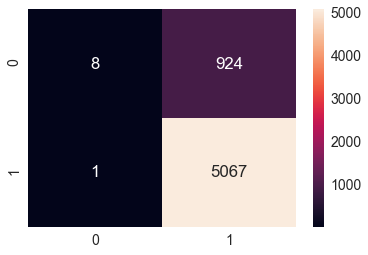

In [272]:
#confusion matrix
from sklearn.metrics import confusion_matrix
df_cm=pd.DataFrame(confusion_matrix(y_test, pred))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt='d')

The accuracy seems to be good and even the TP value is high,so the model is good.

In [274]:
#gridsearchcv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#params we need to try on classifier
knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':np.arange(1,40,2)} 
#For time based splitting
t = TimeSeriesSplit(n_splits=10) 

gsv = GridSearchCV(knn,param_grid,cv=t)
gsv.fit(x_1,y_1)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 85.19%


In [275]:
#accuracy
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier is %f%%' % ( acc))


The accuracy of the knn classifier is 84.550000%


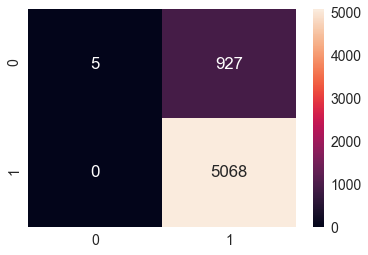

In [276]:
#confusion matrix
from sklearn.metrics import confusion_matrix
df_cm=pd.DataFrame(confusion_matrix(y_test, pred))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt='d')

The TP and accuracy is good so the model is good with k=13

# Tfidf

In [277]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [278]:
#bigrams
tfidf=TfidfVectorizer(ngram_range=(1,2))
tdata=tfidf.fit_transform(d.cleaned.values)

In [279]:
x=tdata
y=d.Score

In [280]:
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

using cross_val_score

In [281]:
cv_scores=[]
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    scores=cross_val_score(knn,x_1,y_1,cv=10,scoring="accuracy")
    cv_scores.append(scores.mean())
print(cv_scores)
    

[0.8144278191687124, 0.84871303090315, 0.8592849716468514, 0.8624992577984552, 0.8611416553565296, 0.8612134924558635, 0.8602136449705187, 0.8595708897227572, 0.8597855836734029, 0.8594280324341274, 0.859356450764953, 0.858642215961772, 0.8584280831994594, 0.8584279812314772, 0.8580708893583255, 0.8576423688408588, 0.8576423688408588, 0.857285276967707, 0.8573568586368813, 0.8568567565231267, 0.8568567055391355, 0.8569280319968093, 0.8565710420916396, 0.856071144132508, 0.8558567563044676]


we have got the accuracy scores for different k values,now lets calculate the error i.e 1-accuracy

In [283]:
#calculating error
error=[1-x for x in cv_scores]
print(error)

[0.18557218083128757, 0.15128696909685002, 0.14071502835314864, 0.13750074220154485, 0.13885834464347035, 0.13878650754413646, 0.13978635502948134, 0.1404291102772428, 0.14021441632659715, 0.14057196756587265, 0.14064354923504696, 0.14135778403822796, 0.1415719168005406, 0.14157201876852277, 0.14192911064167446, 0.14235763115914124, 0.14235763115914124, 0.14271472303229304, 0.14264314136311873, 0.14314324347687335, 0.1431432944608645, 0.14307196800319066, 0.1434289579083604, 0.14392885586749204, 0.14414324369553244]


In [284]:
#finding k with least error
optimal_k=neighbors[error.index(min(error))]
print(optimal_k)

7


performance can be measured using different methods i have used 1. accuracy_score 2. confusion matrix

In [285]:
#accuracy
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))



The accuracy of the knn classifier for k = 7 is 85.516667%


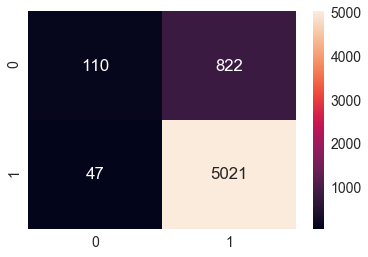

In [286]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
df_cm=pd.DataFrame(confusion_matrix(y_test, pred))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt='d')

the accuracy and TP are good ,so the model is good.

In [287]:
#gridsearch cv
from sklearn.model_selection import GridSearchCV as g
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='brute')
#params we need to try on classifier
param_grid = {'n_neighbors':np.arange(1,40,2)} 
#For time based splitting
t = TimeSeriesSplit(n_splits=10) 

gsv = g(knn,param_grid,cv=t)
gsv.fit(x_1,y_1)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 85.90%



The accuracy of the knn classifier is 85.566667%


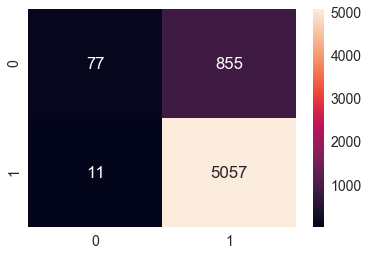

In [288]:
from sklearn.metrics import confusion_matrix
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier is %f%%' % ( acc))
df_cm=pd.DataFrame(confusion_matrix(y_test, pred))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt='d')

The TP and accuracy are good,so,the model is good.

# Word2Vec

In [224]:
from gensim.models import Word2Vec
#making list of sentences
import string
i=0
list_s=[]
for s in d.Text.values:
    filtered=[]
    s=cleanhtml(s)
    for w in s.split():
        for c_w in cleanpunc(w).split():
            if c_w.isalpha():
                filtered.append(c_w.lower())
            else:
                continue
    list_s.append(filtered)
#training our own model
w2v_model=Word2Vec(list_s,min_count=5,size=50,workers=4)

# Average word2vec

In [290]:
#creating avg word2vec
sv=[]
for s in list_s:
    sum=np.zeros(50)
    i=0
    for w in s:
        try:
            
            x=w2v_model.wv[w]
            sum+=x
            i+=1
        except:
            pass
    sum/=i
    sv.append(sum)
    
#cheking the dimension
print(len(sv))
print(len(sv[0]))

20000
50


In [291]:
x=np.asarray(sv)
y=d.Score

In [292]:
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

I have used two ways to find k <br>1. cross_val_score <br>2. gridsearchcv

In [293]:
#cross_val_score
cv_scores=[]
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn,x_1,y_1,cv=10,scoring="accuracy")
    cv_scores.append(scores.mean())
print(cv_scores)
    

[0.8007867973037597, 0.8420018051029619, 0.8487147146868079, 0.8556422669457631, 0.8577143080539471, 0.859143033382014, 0.8613578294464144, 0.8614292069609657, 0.8597866043007455, 0.8606435943516881, 0.8600010432585498, 0.8603578799930874, 0.8587865022598772, 0.8592864512029997, 0.8582859917639901, 0.8592150227044577, 0.8599291552481112, 0.8597149206635892, 0.8593576246358143, 0.8591433389215286, 0.8585716550657132, 0.858000124161871, 0.8578573180030048, 0.858214409949043, 0.8574999709183526]


we got accuracy score for different k values , so the lets calculate error i.e. 1-accuracy

In [295]:
#cal error
error=[1-x for x in cv_scores]
print(error)

[0.19921320269624032, 0.15799819489703815, 0.15128528531319207, 0.14435773305423694, 0.1422856919460529, 0.14085696661798597, 0.13864217055358563, 0.1385707930390343, 0.1402133956992545, 0.13935640564831187, 0.13999895674145024, 0.13964212000691256, 0.14121349774012282, 0.14071354879700027, 0.14171400823600988, 0.1407849772955423, 0.1400708447518888, 0.14028507933641077, 0.14064237536418567, 0.1408566610784714, 0.1414283449342868, 0.141999875838129, 0.1421426819969952, 0.14178559005095703, 0.14250002908164738]


In [296]:
#finding the k value with least error
optimal_k=neighbors[error.index(min(error))]
print(optimal_k)

15


performance measured with accuracy score and confusion matirx


The accuracy of the knn classifier for k = 15 is 85.333333%


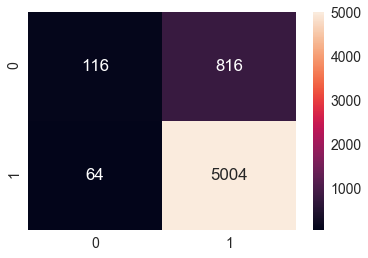

In [297]:
from sklearn.metrics import confusion_matrix
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
df_cm=pd.DataFrame(confusion_matrix(y_test, pred))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt='d')

The TP and accuracy score are quiet good ,so the model seems to be good

In [300]:
#gridsearchcv
from sklearn.model_selection import GridSearchCV as g
from sklearn.model_selection import TimeSeriesSplit
knn = KNeighborsClassifier(algorithm='brute')
#params we need to try on classifier
param_grid = {'n_neighbors':np.arange(1,40,2)} 
#For time based splitting
t = TimeSeriesSplit(n_splits=10)

gsv = g(knn,param_grid,cv=t)
gsv.fit(x_1,y_1)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'n_neighbors': 31}
Best Accuracy: 85.59%


Performance :


The accuracy of the knn classifier is 85.083333%


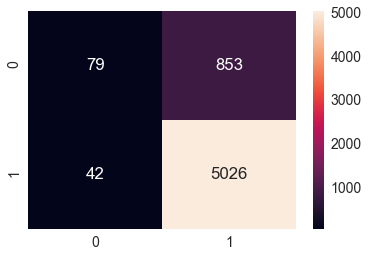

In [301]:
from sklearn.metrics import confusion_matrix
knn=KNeighborsClassifier(n_neighbors=31)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier is %f%%' % ( acc))
df_cm=pd.DataFrame(confusion_matrix(y_test, pred))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,annot=True,fmt='d')

The TP and the accuracy are good .so the model is good

# Tfidf word2vec

In [225]:
tfidf_feat = tfidf.get_feature_names()
tf=tfidf.fit_transform(d.Text.values)
tfidfsv = []
row=0;
for s in list_s: 
    sum = np.zeros(50) 
    i=0; 
    for word in s: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = tf[row, tfidf_feat.index(word)]
            sum += (vec * tf_idf)
            i += tf_idf
        except:
            pass
    sum /= i
    tfidfsv.append(sum)
    row += 1

In [226]:
x=np.asarray(tfidfsv)
y=d.Score
x

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [245]:
#splitting of the data
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.3)

x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

The 'x' array has 'NaN' values we have to change them .

In [246]:
# changing 'NaN' to numeric value
x_1=np.isnan(x_1)
np.where(np.isnan(x_1))
np.nan_to_num(x_1)

x_test=np.isnan(x_test)
np.where(np.isnan(x_test))
np.nan_to_num(x_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

I have used two ways to identify hyperparameter(k) value :<br>1. using the cross validation score.<br>2. using gridsearchcv
<br><br>lets see both of them

In [249]:
#neighors=(1,50,2)
cv_scores=[]
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,x_1,y_1,cv=10,scoring="accuracy")
    cv_scores.append(scores.mean())
print(cv_scores)

[0.6411209697045763, 0.710835255418862, 0.7801428928207178, 0.7105714642492893, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323, 0.8499286071064323]


We have got cv_scores it basically has the accuracy score repective to k neighbor,now lets see what is the error i.e. nothing but 1-accuracy.

In [250]:
#calculation of error
error=[1-x for x in cv_scores]
print(error)

[0.3588790302954237, 0.28916474458113794, 0.2198571071792822, 0.2894285357507107, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775, 0.15007139289356775]


In [251]:
#finding k with least error
optimal_k=neighbors[error.index(min(error))]
print(optimal_k)

9


We can measure the accuracy by accuracy but it is not the only method .confusion matrix is also one the method.

In [257]:
#measuring with accuracy
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))




The accuracy of the knn classifier for k = 9 is 85.016667%


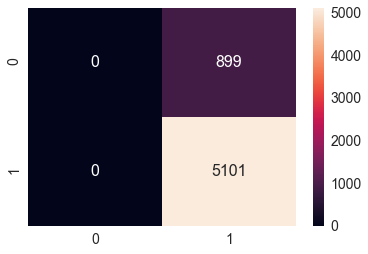

In [258]:
#confusion matirx
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

the accuracy is high and even TP in confusion is high.so we can say model is good.

In [254]:
#gridsearch_cv
from sklearn.model_selection import GridSearchCV as g
from sklearn.model_selection import TimeSeriesSplit
knn = KNeighborsClassifier(algorithm='brute')
#parameter to implement on classifier
param_grid = {'n_neighbors':np.arange(1,40,2)}
#time based splitting
t = TimeSeriesSplit(n_splits=10) 

gsv = g(knn,param_grid,cv=t)
gsv.fit(x_1,y_1)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'n_neighbors': 1}
Best Accuracy: 85.06%



The accuracy of the knn classifier is 15.400000%


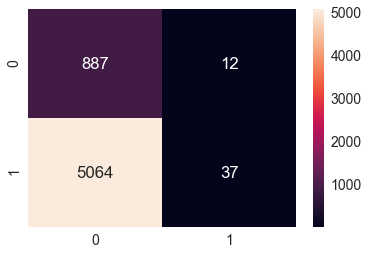

In [256]:
from sklearn.metrics import confusion_matrix
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(x_1,y_1)
pred=knn.predict(x_test)
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier is %f%%' % (acc))

df_cm = pd.DataFrame(confusion_matrix(y_test, pred))
#size of the label
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

the accuracy is very less for the test data and we saw that we had high accuracy in train data, k is small so, the model seems to overfitting 

# Conclusion :
<br>1.The more the data ,more will be the accuracy.
<br>2.if the test and train data have different distribution,the model does not work properly ,as we can see in tfidf word2vec i.e above cell our train accuracy is good but the test accuracy is vey low .
<br>3.you cannot pass sparse matrix to the kdtree.
<br>4.doing cross validation can increase your train data which increases your accuracy as we know more the data more is the accuracy.